In [82]:
import sys
sys.path.append('../')

In [83]:
import game.agent as ag
from game.run import run
from game.simulator import load_simulator_yarn, GraphSimulator
from pathlib import Path
from tqdm.auto import trange
import pandas as pd
# import mpire
import torch

In [84]:
n_runs = int(1e4)
# n_runs = int(100)
seed = None

In [85]:
simulator = load_simulator_yarn('../yarnScripts', graph_file_sfx='_graph_transformed.pickle')

In [86]:
# label_predictor=ag.TorchLabelPredictor(
#             model_path=Path('./saved_bert/200_[20]_[30]_1_False_bert-base-multilingual-cased_0.001_adamw_8_max_val_mcc_False_False_100'),
#             use_cpu=False,
#         )

def get_random_agent():
    return ag.RandomAgent(None)

# def get_r_agent():
#     return ag.LabelDecisorAgent(
#         label_predictor=ag.GraphLabelLoader(
#             simulator=simulator,
#         ),
#         decision_maker=ag.RDecisionMaker(
#             rand=0.4,
#             seed=None,
#         )
#     )

def get_risky_agent():
    return ag.LabelDecisorAgent(
        label_predictor=ag.GraphLabelLoader(
            simulator=simulator,
        ),
        decision_maker=ag.BehavioralDecisionMaker(
            weight_funcs=[
                lambda x: x
            ],
            memory_steps=0,
            seed=None,
        )
    )

# def get_not_risky_agent():
#     return ag.BehavioralDecisionMaker(
#         weight_funcs=[
#             lambda x: -x
#         ],
#         memory_steps=0,
#         seed=None,
#     )

# def get_b_agent():
#     return ag.BehavioralDecisionMaker(
#         weight_funcs=[
#             lambda x: x*torch.as_tensor([0.5, -0.4, -0.3, -0.2])
#         ],
#         memory_steps=3,
#         seed=None,
#     )

# def get_mc_agent():
#     return ag.LabelDecisorAgent(
#         label_predictor=ag.GraphLabelLoader(
#             simulator=simulator,
#         ),
#         decisor=ag.MarkovChainAgent(
#             rand=0.4,
#             seed=None,
#         )
#     )

## Random Agent

In [87]:
df = run(get_random_agent, simulator, n_runs)

100%|██████████| 10000/10000 [00:01<00:00, 5522.08it/s]


In [88]:
print(df['endings'])

       run         title kind
0        0    MaloPadres    0
1        1    MaloPadres    0
2        2  MaloSilencio    0
3        3  MaloSilencio    0
4        4   BuenoAmanda    1
...    ...           ...  ...
9995  9995    MaloAmigos    0
9996  9996  MaloSilencio    0
9997  9997    MaloAmigos    0
9998  9998  MaloSilencio    0
9999  9999    MaloPadres    0

[10000 rows x 3 columns]


In [89]:
df['decisions'].groupby(['num']).mean()
# diferencia entre estos valores y los otros nos dice si tiene predilección por label o no

,run,choice,label
num,,,
0,4999.500000,0.492800,NaN
1,4999.500000,0.501500,0.501500
2,4999.500000,0.000000,NaN
3,4999.500000,0.498000,NaN
4,4999.500000,0.000000,NaN
5,4999.500000,0.494000,0.506000
6,4999.500000,0.493100,0.493100
7,4999.500000,0.507800,0.507800
8,4999.500000,0.373800,0.500402


In [90]:
rand = df['decisions'].groupby(['num']).mean()
rand['m'] = 0

In [91]:
# df.to_csv('endings.csv')

## R Agent

In [92]:
# df = run(get_r_agent, simulator, n_runs)

## Risky Agent

In [103]:
df = run(get_risky_agent, simulator, n_runs)

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\vibal\PycharmProjects\text-games\notebooks\..\game\agent.py:230: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self._p = F.softmax((pred * w[None, :]).sum(1)) # (actions, labels) -> (actions)
100%|██████████| 10000/10000 [00:34<00:00, 292.53it/s]


In [104]:
print(df['endings'])

       run         title kind
0        0    MaloPadres    0
1        1    MaloAmanda    0
2        2  MaloSilencio    0
3        3  MaloSilencio    0
4        4    MaloAmigos    0
...    ...           ...  ...
9995  9995  MaloSilencio    0
9996  9996    MaloAmanda    0
9997  9997    MaloPadres    0
9998  9998  MaloSilencio    0
9999  9999    MaloAmanda    0

[10000 rows x 3 columns]


In [105]:
df['decisions'].groupby(['num']).mean()
# diferencia entre estos valores y los otros nos dice si tiene predilección por label o no

,run,choice,label
num,,,
0,4999.500000,0.336400,NaN
1,4999.500000,0.588900,0.588900
2,4999.500000,0.000000,NaN
3,4999.500000,0.504700,NaN
4,4999.500000,0.000000,NaN
5,4999.500000,0.278100,0.721900
6,4999.500000,0.571800,0.571800
7,4999.500000,0.571600,0.571600
8,4999.500000,0.450700,0.553890


<AxesSubplot:xlabel='num'>

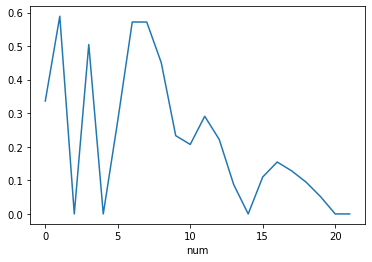

In [107]:
df['decisions'].groupby(['num']).mean()['choice'].plot()

In [96]:
risk = df['decisions'].groupby(['num']).mean()
risk['m'] = 1

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [98]:
df = pd.concat([rand,risk])
df = df.reset_index()
df = df.dropna()

df_train,df_test = train_test_split(df, test_size=0.3)

In [99]:
dt = DecisionTreeClassifier()
dt.fit(df_train.loc[:,df.columns!='m'], df_train['m'])

lr = LogisticRegression()
lr.fit(df_train.loc[:,df.columns!='m'], df_train['m'])

LogisticRegression()

In [100]:
dt.score(df_test.loc[:,df.columns!='m'], df_test['m'])

0.9

In [101]:
lr.score(df_test.loc[:,df.columns!='m'], df_test['m'])

0.4

## Risky Agent

In [ ]:
df = run(get_not_risky_agent, simulator, n_runs)

## More risk choices, less risky Agent

In [ ]:
df = run(get_b_agent, simulator, n_runs)

## Markov Chain Agents